In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import logging
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import helpers as hp

In [3]:
tf.get_logger().setLevel(logging.ERROR)

In [4]:
commands, nums = hp.get_commands_dict('commands.csv')

In [5]:
all_speakers = ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
dataset = dict()
for speaker in all_speakers:
    data = hp.load_from_datafile(f'data/{speaker}_data.npy')
    labels = hp.load_from_datafile(f'data/{speaker}_labels.npy')

    data = data.reshape(data.shape + (1,))
    labels = to_categorical([hp.get_num_by_command(label, commands) for label in labels], num_classes=11)
    idx = np.random.permutation(data.shape[0])
    data, labels = data[idx], labels[idx]
    
    dataset[speaker] = {
        'data':   data,
        'labels': labels 
    }
    
    print(f'{speaker} data shape: {dataset[speaker]["data"].shape}')
    print(f'{speaker} labels shape: {dataset[speaker]["labels"].shape}')

speaker1 data shape: (550, 400, 13, 1)
speaker1 labels shape: (550, 11)
speaker2 data shape: (440, 400, 13, 1)
speaker2 labels shape: (440, 11)
speaker3 data shape: (440, 400, 13, 1)
speaker3 labels shape: (440, 11)
speaker4 data shape: (440, 400, 13, 1)
speaker4 labels shape: (440, 11)
speaker5 data shape: (550, 400, 13, 1)
speaker5 labels shape: (550, 11)
speaker6 data shape: (550, 400, 13, 1)
speaker6 labels shape: (550, 11)


In [6]:
test_size = 0.3
cnn_test_summary = []
mlp_test_summary = []
threshold_list = [0.5, 0.6, 0.7, 0.8]

In [7]:
def run_experiment(experiment_num, train_list, test_list, train_list_shortname, nn_type, 
                   threshold_list, plot_model=False, plot_cm=True, 
                   cm_save_path=None, tg_save=False):
    print('='*10) 
    print(f'Running experiment\n',
          f'Train dataset : {train_list}\n',
          f'Test dataset : {test_list}\n',
          f'Network type is {nn_type.upper()}.')
    # Set train data
    train_data = []
    train_labels = []
    for speaker in train_list:
        train_data.append(dataset[speaker]['data'][:np.floor(dataset[speaker]['data'].shape[0]*(1-test_size)).astype(int), ...])
        train_labels.append(dataset[speaker]['labels'][:np.floor(dataset[speaker]['labels'].shape[0]*(1-test_size)).astype(int), ...])
    train_data = np.concatenate(train_data, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)
    
    # Set test data
    test_data = []
    test_labels = []
    test_dict = dict()
    for speaker in test_list:
        test_data.append(dataset[speaker]['data'][np.floor(dataset[speaker]['data'].shape[0]*(1-test_size)).astype(int):, ...])
        test_labels.append(dataset[speaker]['labels'][np.floor(dataset[speaker]['labels'].shape[0]*(1-test_size)).astype(int):, ...])
        test_dict[speaker] = {
            'data': dataset[speaker]['data'][np.floor(dataset[speaker]['data'].shape[0]*(1-test_size)).astype(int):, ...] ,
            'labels': dataset[speaker]['labels'][np.floor(dataset[speaker]['labels'].shape[0]*(1-test_size)).astype(int):, ...]
        }
    test_data = np.concatenate(test_data, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)
        
    print('---Train dataset---')
    print(f'Contains speakers : {train_list}')
    print(f'data shape : {train_data.shape}')
    print(f'labels shape : {train_labels.shape}')
    
    print('---Test dataset---')
    print(f'Contains speakers : {test_list}')
    for speaker in test_list:
        print(f'{speaker} data shape : {test_dict[speaker]["data"].shape}')
        print(f'{speaker} labels shape : {test_dict[speaker]["labels"].shape}')
    
    # Train
    if nn_type == 'mlp':
        model = hp.get_mlp_model()
        if plot_model:
            tf.keras.utils.plot_model(model, to_file='article/img/mlp_model.png')
    elif nn_type == 'cnn':
        model = hp.get_cnn_model()
        if plot_model:
            tf.keras.utils.plot_model(model, to_file='article/img/cnn_model.png')
        
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    checkpoint_best_filepath = f'model_checkpoints/experiment{experiment_num}/{nn_type}/best_only'
    checkpoint_best_only = ModelCheckpoint(save_freq='epoch', save_best_only=True,
                                           filepath=checkpoint_best_filepath, verbose=0) 
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0)

    print('---Training stage---')
    history = model.fit(train_data, train_labels, epochs=50, batch_size=256, validation_split=0.15, 
                        callbacks=[early_stopping, checkpoint_best_only], 
                        verbose=0)

    tg_save_path = None
    if tg_save:
        tg_save_path = os.path.join('article', 'img', f'{nn_type}_{train_list_shortname}_train_graphs.png')
    hp.plot_metrics(history, save_path=tg_save_path)
    
    # Test
    print('---Testing stage---')
    for speaker in test_list:
        test_loss, test_accuracy = model.evaluate(test_dict[speaker]['data'], test_dict[speaker]['labels'], verbose=0)
        print(f"{speaker} - test loss : {test_loss:0.3f} - test accuracy : {test_accuracy:0.3f}")
        
        if nn_type == 'cnn':
            cnn_test_summary.append([train_list_shortname, speaker, round(test_loss, 3), round(test_accuracy, 3)])   
        else:
            mlp_test_summary.append([train_list_shortname, speaker, round(test_loss, 3), round(test_accuracy, 3)])        
    
    if plot_cm:
        cm_arr = list()
        for threshold in threshold_list:
            cm, metrics = hp.get_confusion_matrix(test_labels, model.predict(test_data), nums, threshold=threshold)
            cm_arr.append({
                'cm': cm, 
                'threshold': threshold,
                'metrics': metrics
            })
            
        if cm_save_path:
            cm_save_path = os.path.join('article', 'img', f'{nn_type}_cm_{cm_save_path}.png')
        hp.plot_confusion_matrix(cm_arr, cm_save_path)
        
        prec_df = None
        for cm in cm_arr:
            if prec_df is None:
                prec_df = pd.DataFrame(cm['metrics'], index=hp.get_commands_list_with_silence(nums)).T
                continue
            prec_df = pd.concat((prec_df, pd.DataFrame(cm['metrics'], index=hp.get_commands_list_with_silence(nums)).T))
        prec_df = prec_df[hp.get_commands_list(nums)]
        display(prec_df)
        
        prec_df.to_csv(os.path.join('article', 'csv', f'{nn_type}_{train_list_shortname}_precisions_for_thresholds.csv'), index=True)
        
    
    print('Finished experiment.')
    print('='*10)       

Running experiment
 Train dataset : ['speaker1']
 Test dataset : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
 Network type is CNN.
---Train dataset---
Contains speakers : ['speaker1']
data shape : (385, 400, 13, 1)
labels shape : (385, 11)
---Test dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
speaker1 data shape : (165, 400, 13, 1)
speaker1 labels shape : (165, 11)
speaker2 data shape : (132, 400, 13, 1)
speaker2 labels shape : (132, 11)
speaker3 data shape : (132, 400, 13, 1)
speaker3 labels shape : (132, 11)
speaker4 data shape : (132, 400, 13, 1)
speaker4 labels shape : (132, 11)
speaker5 data shape : (165, 400, 13, 1)
speaker5 labels shape : (165, 11)
speaker6 data shape : (165, 400, 13, 1)
speaker6 labels shape : (165, 11)
---Training stage---


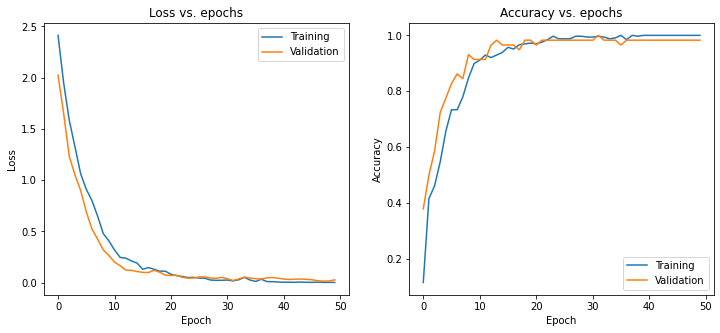

---Testing stage---
speaker1 - test loss : 0.035 - test accuracy : 0.988
speaker2 - test loss : 12.730 - test accuracy : 0.144
speaker3 - test loss : 4.241 - test accuracy : 0.356
speaker4 - test loss : 11.544 - test accuracy : 0.121
speaker5 - test loss : 2.291 - test accuracy : 0.673
speaker6 - test loss : 22.004 - test accuracy : 0.230
Finished experiment.
Running experiment
 Train dataset : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5']
 Test dataset : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
 Network type is CNN.
---Train dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5']
data shape : (1694, 400, 13, 1)
labels shape : (1694, 11)
---Test dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
speaker1 data shape : (165, 400, 13, 1)
speaker1 labels shape : (165, 11)
speaker2 data shape : (132, 400, 13, 1)
speaker2 labels shape : (132, 11)
speaker3 da

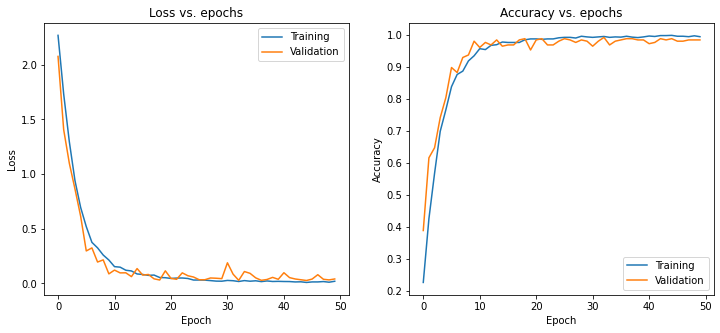

---Testing stage---
speaker1 - test loss : 0.063 - test accuracy : 0.976
speaker2 - test loss : 0.100 - test accuracy : 0.970
speaker3 - test loss : 0.157 - test accuracy : 0.955
speaker4 - test loss : 0.420 - test accuracy : 0.917
speaker5 - test loss : 0.053 - test accuracy : 0.976
speaker6 - test loss : 7.688 - test accuracy : 0.448
Finished experiment.
Running experiment
 Train dataset : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
 Test dataset : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
 Network type is CNN.
---Train dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
data shape : (2079, 400, 13, 1)
labels shape : (2079, 11)
---Test dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
speaker1 data shape : (165, 400, 13, 1)
speaker1 labels shape : (165, 11)
speaker2 data shape : (132, 400, 13, 1)
speaker2 labels shape : 

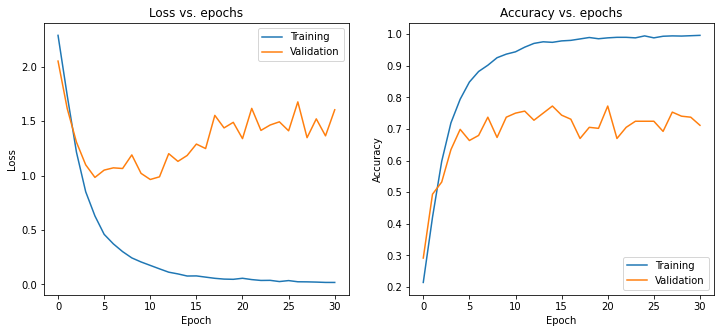

---Testing stage---
speaker1 - test loss : 0.069 - test accuracy : 0.970
speaker2 - test loss : 0.083 - test accuracy : 0.977
speaker3 - test loss : 0.079 - test accuracy : 0.985
speaker4 - test loss : 0.318 - test accuracy : 0.932
speaker5 - test loss : 0.016 - test accuracy : 0.994
speaker6 - test loss : 1.685 - test accuracy : 0.745


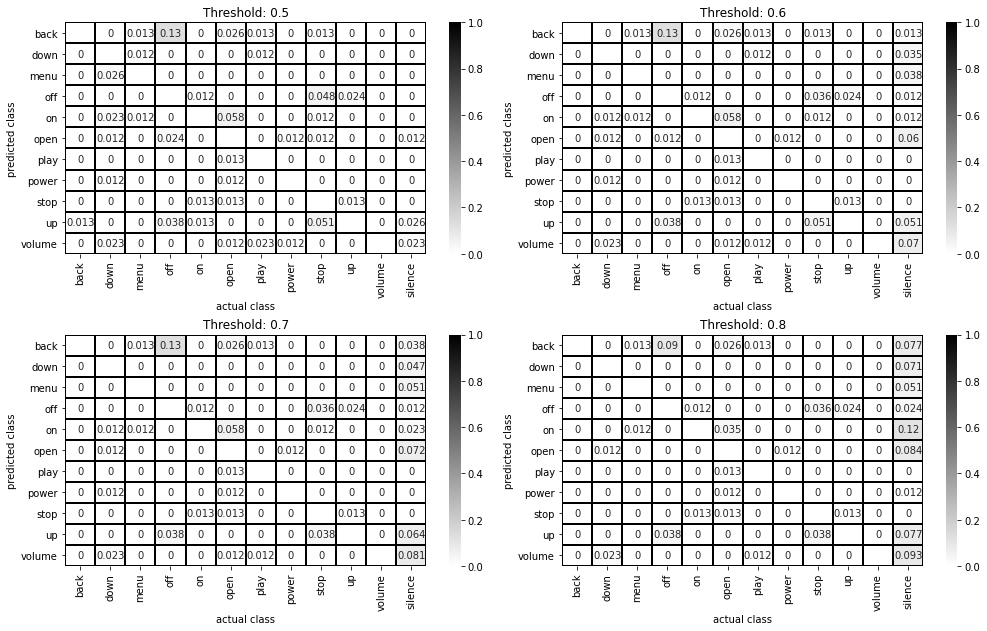

,back,down,menu,off,on,open,play,power,stop,up,volume
precision_for_threshold=0.5,0.808,0.976,0.974,0.917,0.895,0.928,0.987,0.976,0.96,0.859,0.907
precision_for_threshold=0.6,0.795,0.953,0.962,0.917,0.895,0.904,0.987,0.976,0.96,0.859,0.884
precision_for_threshold=0.7,0.782,0.953,0.949,0.917,0.884,0.904,0.987,0.976,0.96,0.859,0.872
precision_for_threshold=0.8,0.782,0.929,0.949,0.905,0.837,0.892,0.987,0.976,0.96,0.846,0.872


Finished experiment.
Running experiment
 Train dataset : ['speaker1']
 Test dataset : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
 Network type is MLP.
---Train dataset---
Contains speakers : ['speaker1']
data shape : (385, 400, 13, 1)
labels shape : (385, 11)
---Test dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
speaker1 data shape : (165, 400, 13, 1)
speaker1 labels shape : (165, 11)
speaker2 data shape : (132, 400, 13, 1)
speaker2 labels shape : (132, 11)
speaker3 data shape : (132, 400, 13, 1)
speaker3 labels shape : (132, 11)
speaker4 data shape : (132, 400, 13, 1)
speaker4 labels shape : (132, 11)
speaker5 data shape : (165, 400, 13, 1)
speaker5 labels shape : (165, 11)
speaker6 data shape : (165, 400, 13, 1)
speaker6 labels shape : (165, 11)
---Training stage---


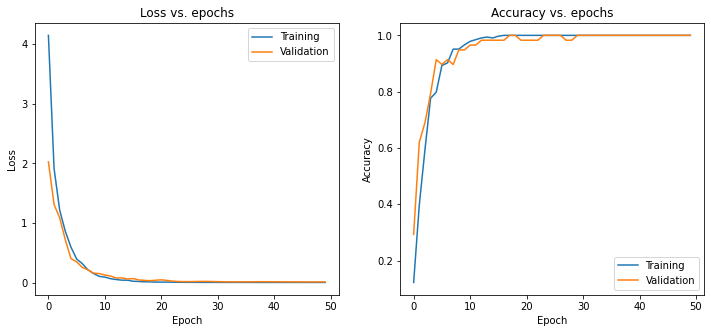

---Testing stage---
speaker1 - test loss : 0.039 - test accuracy : 0.982
speaker2 - test loss : 9.798 - test accuracy : 0.167
speaker3 - test loss : 3.243 - test accuracy : 0.326
speaker4 - test loss : 7.385 - test accuracy : 0.152
speaker5 - test loss : 2.866 - test accuracy : 0.612
speaker6 - test loss : 10.063 - test accuracy : 0.139
Finished experiment.
Running experiment
 Train dataset : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5']
 Test dataset : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
 Network type is MLP.
---Train dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5']
data shape : (1694, 400, 13, 1)
labels shape : (1694, 11)
---Test dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
speaker1 data shape : (165, 400, 13, 1)
speaker1 labels shape : (165, 11)
speaker2 data shape : (132, 400, 13, 1)
speaker2 labels shape : (132, 11)
speaker3 data

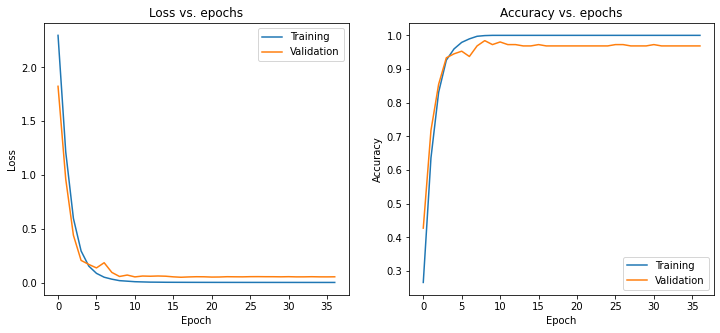

---Testing stage---
speaker1 - test loss : 0.044 - test accuracy : 0.982
speaker2 - test loss : 0.301 - test accuracy : 0.924
speaker3 - test loss : 0.182 - test accuracy : 0.962
speaker4 - test loss : 0.392 - test accuracy : 0.902
speaker5 - test loss : 0.058 - test accuracy : 0.970
speaker6 - test loss : 6.398 - test accuracy : 0.248
Finished experiment.
Running experiment
 Train dataset : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
 Test dataset : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
 Network type is MLP.
---Train dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
data shape : (2079, 400, 13, 1)
labels shape : (2079, 11)
---Test dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
speaker1 data shape : (165, 400, 13, 1)
speaker1 labels shape : (165, 11)
speaker2 data shape : (132, 400, 13, 1)
speaker2 labels shape : 

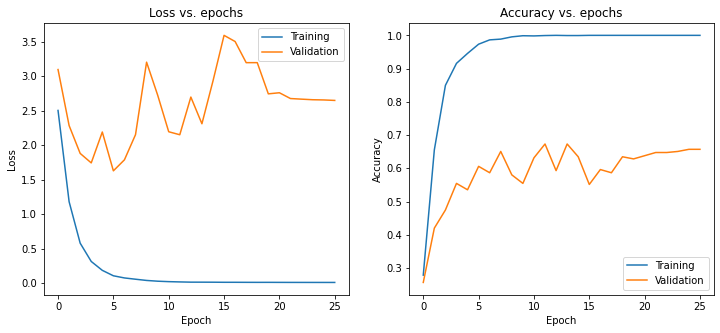

---Testing stage---
speaker1 - test loss : 0.022 - test accuracy : 1.000
speaker2 - test loss : 0.309 - test accuracy : 0.917
speaker3 - test loss : 0.141 - test accuracy : 0.962
speaker4 - test loss : 0.384 - test accuracy : 0.917
speaker5 - test loss : 0.010 - test accuracy : 1.000
speaker6 - test loss : 2.503 - test accuracy : 0.691


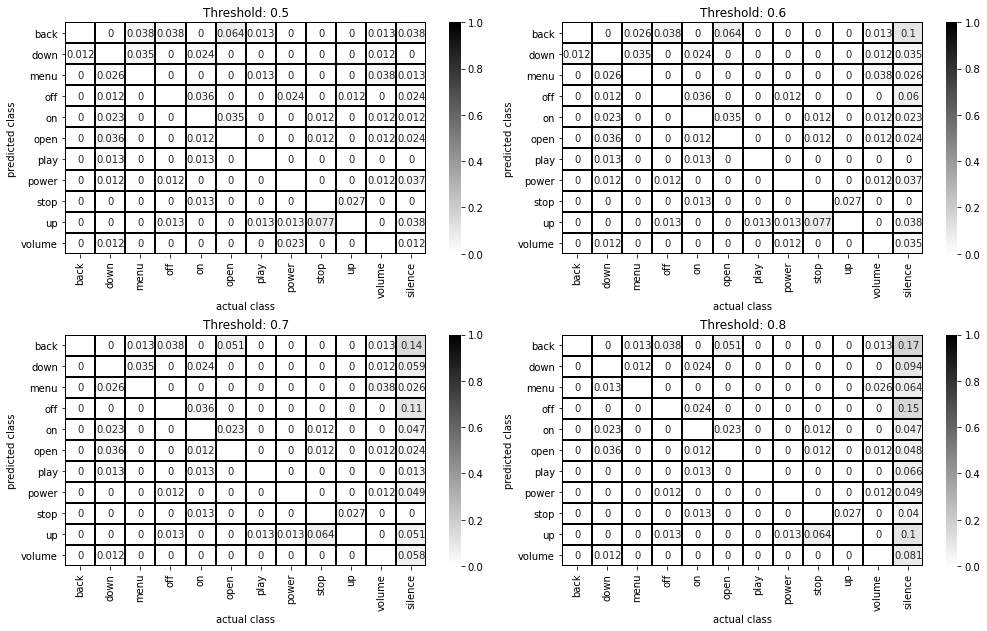

,back,down,menu,off,on,open,play,power,stop,up,volume
precision_for_threshold=0.5,0.795,0.918,0.910,0.893,0.907,0.904,0.974,0.927,0.96,0.846,0.953
precision_for_threshold=0.6,0.756,0.882,0.910,0.881,0.895,0.904,0.974,0.927,0.96,0.846,0.942
precision_for_threshold=0.7,0.744,0.871,0.910,0.857,0.895,0.904,0.961,0.927,0.96,0.846,0.930
precision_for_threshold=0.8,0.718,0.871,0.897,0.821,0.895,0.880,0.921,0.927,0.92,0.808,0.907


Finished experiment.


In [8]:
for nn_type in ['cnn', 'mlp']:
    run_experiment(1, ['speaker1'], all_speakers, 'speaker1', nn_type, threshold_list, True, False, tg_save=True)
    run_experiment(2, ['speaker1','speaker2','speaker3','speaker4','speaker5'], all_speakers, 'all_male_speakers', nn_type, threshold_list, False, False, tg_save=True)
    run_experiment(3, all_speakers, all_speakers, 'all_speakers', nn_type, threshold_list, False, True, 'all_speakers', tg_save=True)

In [9]:
cnn_cols = ['train_data', 'test_speaker', 'cnn_loss', 'cnn_accuracy']
mlp_cols = ['train_data', 'test_speaker', 'mlp_loss', 'mlp_accuracy']

compare_order = ['train_data', 'test_speaker', 'cnn_loss', 'mlp_loss', 'cnn_accuracy', 'mlp_accuracy']
cnn_df = pd.DataFrame(cnn_test_summary, columns=cnn_cols)
mlp_df = pd.DataFrame(mlp_test_summary, columns=mlp_cols)
cols_to_use = mlp_df.columns.difference(cnn_df.columns)
final_df = pd.merge(cnn_df, mlp_df[cols_to_use], left_index=True, right_index=True, how='outer')[compare_order]
pd.set_option('display.max_colwidth', None)
display(final_df)
final_df.to_csv('article/csv/test_summary.csv', index=False)

,train_data,test_speaker,cnn_loss,mlp_loss,cnn_accuracy,mlp_accuracy
0,speaker1,speaker1,0.035,0.039,0.988,0.982
1,speaker1,speaker2,12.730,9.798,0.144,0.167
2,speaker1,speaker3,4.241,3.243,0.356,0.326
3,speaker1,speaker4,11.544,7.385,0.121,0.152
4,speaker1,speaker5,2.291,2.866,0.673,0.612
5,speaker1,speaker6,22.004,10.063,0.230,0.139
6,all_male_speakers,speaker1,0.063,0.044,0.976,0.982
7,all_male_speakers,speaker2,0.100,0.301,0.970,0.924
8,all_male_speakers,speaker3,0.157,0.182,0.955,0.962
9,all_male_speakers,speaker4,0.420,0.392,0.917,0.902
